# 5. Video Stitching and Processing

### Setup


In [21]:
datadir = "/Users/marchon/Downloads/proj5/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
imagesfn = datadir + "images"
!cp -r "$imagesfn" .

In [3]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit to use SIFT
!pip install opencv-contrib-python==4.9.0.80 --force-reinstall
!pip install ffmpeg-python # for converting to video

import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 65.4 MB 170 kB/s eta 0:00:01    |▋                               | 1.4 MB 207 kB/s eta 0:05:10     |████▊                           | 9.7 MB 114 kB/s eta 0:08:09     |█████▌                          | 11.2 MB 212 kB/s eta 0:04:15     |████████                        | 16.2 MB 216 kB/s eta 0:03:48     |████████▏                       | 16.7 MB 216 kB/s eta 0:03:46     |███████████▊                    | 24.1 MB 203 kB/s eta 0:03:24     |██████████████▋                 | 29.8 MB 226 kB/s eta 0:02:38     |███████████████▏                | 31.0 MB 222 kB/s eta 0:02:35     |█████████████████▍              | 35.5 MB 236 kB/s eta 0:02:07     |██████████████████████████▍     | 54.0 MB 150 kB/s eta 0:01:17     |██████████████████████████▊     | 54.7 MB 236 kB/s eta 0:00:46     |███████████████████████████████▋| 64.5 MB 234 kB/s eta 0:00:04
     |████████████████████████████████| 20.6 MB 245 kB/s 

### Part I: Stitch two key frames 

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.
homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [22]:
def score_projection(pt1, pt2):
    '''
    Score corresponding to the number of inliers for RANSAC
    Input: pt1 and pt2 are 2xN arrays of N points such that pt1[:, i] and pt2[:,i] should be close in Euclidean distance if they are inliers
    Outputs: score (scalar count of inliers) and inliers (1xN logical array)
    '''

    dist = np.linalg.norm(pt1 - pt2, axis=0)
    inliers = dist < 3

    score = np.count_nonzero(inliers)

    return score, inliers


def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    H = np.eye(3)
    best_score = 0
    n_to_sample = 4 # Put the correct number of points here

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, n_to_sample, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)

        
        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        
        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = inliers_t
    
#     print('best score: {:02f}'.format(best_score))

    return H

In [23]:
def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD. Normalization is optional.
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    assert pts1.shape == pts2.shape
    assert pts1.shape[0] == 3    
    
    if normalization_func:
        pts1 = normalization_func(pts1)
        pts2 = normalization_func(pts2)

    num_points = pts1.shape[1]
    # initialize the matrix A
    A = np.zeros((2 * num_points, 9))

    for i in range(num_points):
        X = pts1[:, i]
        X_prime = pts2[:, i]
        
        x, y, w = X[0], X[1], X[2]
        x_prime, y_prime, w_prime = X_prime[0], X_prime[1], X_prime[2]
        u, v, u_prime, v_prime = x/w, y/w, x_prime/w_prime, y_prime/w_prime
        # add two rows per point to the matrix A
        A[i * 2,:] = [-u, -v, -1, 0, 0, 0, u * u_prime, v * u_prime, u_prime]
        A[i * 2 + 1,:] = [0, 0, 0, -u, -v, -1, u * v_prime, v * v_prime, v_prime]

    # SVD of A
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    
    return H

[[-4.88012152e-03 -2.27943687e-04  1.00000000e+00]
 [-3.32738750e-05 -4.62455256e-03  6.38281472e-02]
 [-1.87845394e-06 -1.06681037e-07 -3.96799003e-03]]


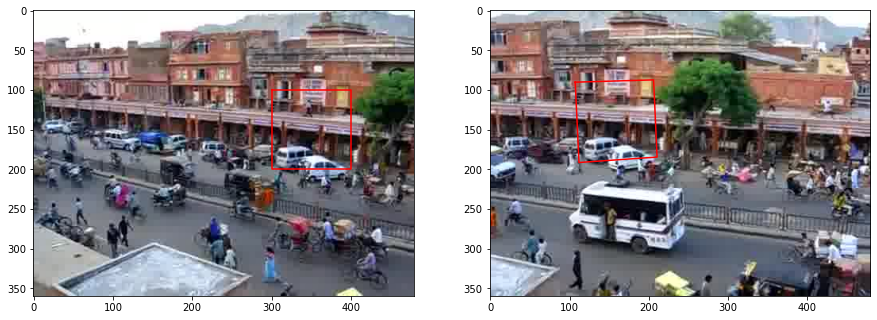

In [136]:
# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

H = auto_homography(im1,im2, computeHomography)
print(H/H.max()) 

# plot the frames here
plt.figure(figsize=(15,6))
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])

plt.subplot(1,2,1)

plt.imshow(im1[:,:,[2,1,0]])
plt.plot(box_pts[0,:], box_pts[1, :], 'r-')

# TO DO: project points into im2 and display the projected lines on im2
box_pts2 = np.dot(H, box_pts)
box_pts2 /= box_pts2[2, :]
    
plt.subplot(1,2,2)
plt.imshow(im2[:,:,[2,1,0]])
plt.plot(box_pts2[0, :], box_pts2[1, :], 'r-')

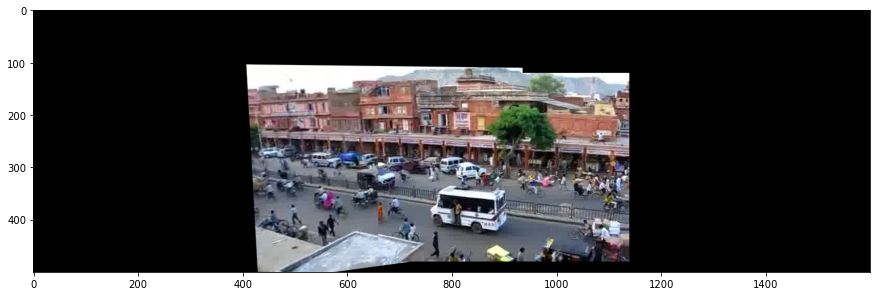

In [140]:
projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

# TO DO: warp and blend the two images
projIm1 = cv2.warpPerspective(im1, np.dot(Tr, H), (projectedWidth, projectedHeight))
blend = projIm1.copy()
start_y = int(Tr[1, 2])
start_x = int(Tr[0, 2])
end_y = start_y + im2.shape[0]
end_x = start_x + im2.shape[1]

if end_y > projectedHeight:
    end_y = projectedHeight
if end_x > projectedWidth:
    end_x = projectedWidth

# place im2 onto the projected image of im1
blend[start_y:end_y, start_x:end_x] = im2[:(end_y-start_y), :(end_x-start_x)]
plt.figure(figsize=(15,6))
plt.imshow(blend[:, :, [2, 1, 0]])
plt.show();

### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


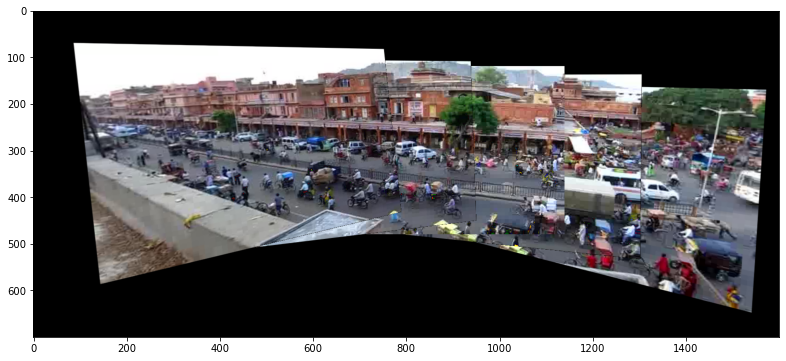

In [141]:
def blendImages(sourceTransform, referenceTransform):
    blendedOutput = np.copy(referenceTransform)
    indices = (referenceTransform == 0)
   
    blendedOutput[indices] = sourceTransform[indices]
    return (blendedOutput / blendedOutput.max() * 255).astype(np.uint8)

# compute homographies between consecutive frames.
def compute_homographies(frames):
    homographies = []
    mid = len(frames) // 2
    for i in range(1, len(frames)):
        if i <= mid:
            homography = auto_homography(frames[i-1], frames[i], computeHomography)
        else:
            homography = auto_homography(frames[i], frames[i - 1], computeHomography)
        homographies.append(homography)
    return homographies

# apply transformations to frames and blend them. 
def apply_transformations(frames, transformations, Tr, width, height):
    blend = np.zeros((height, width, 3))
    for frame, transform in zip(frames, transformations):
        transformed_image = cv2.warpPerspective(frame, np.dot(Tr, transform), (width, height))
        blend = blendImages(transformed_image, blend)
        
    return blend

key_frames_idx = np.array([90, 270, 450, 630, 810])-1
frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
    frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

projectedWidth = 1600
projectedHeight = 700
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

homographies = compute_homographies(frames)
transformations = [
    np.dot(homographies[1], homographies[0]),  # for frame 0
    homographies[1],                           # for frame 1
    np.identity(3),                            # for frame 2
    homographies[2],                           # for frame 3
    np.dot(homographies[3], homographies[2])   # for frame 4
]

blend = apply_transformations(frames, transformations, Tr, projectedWidth, projectedHeight)
plt.figure(figsize=(15,6))
plt.imshow(blend[:, :, [2, 1, 0]]) 
plt.show()

### Part III: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [82]:
# read all the images
import os 
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.imread(file_i)

In [75]:
output_dir = 'input_images'
os.makedirs(output_dir, exist_ok=True)

projectedWidth = 1600
projectedHeight = 700
interval = 1

for i in range(0, len(frames), interval):
    if i < 225:
        target_frame = frames[225]
    elif i < 450:
        target_frame = frames[450]
    elif i == 450:
        target_frame = np.identity(3)
    elif i < 675:
        target_frame = frames[450]
    else:
        target_frame = frames[675]

    # compute homography
    Hn = auto_homography(frames[i], target_frame, computeHomography)

    # apply transformation based on conditions
    if i < 225:
        projIm = cv2.warpPerspective(frames[i], np.dot(Tr, np.dot(Hn, homographies[0])), \
                                     (projectedWidth, projectedHeight))  
    elif i == 450:
        projIm = cv2.warpPerspective(frames[i], np.dot(Tr, target_frame), (projectedWidth, projectedHeight))
    elif i >= 675:
        projIm = cv2.warpPerspective(frames[i], np.dot(Tr, np.dot(homographies[3], Hn)), \
                                     (projectedWidth, projectedHeight))
    else:
        projIm = cv2.warpPerspective(frames[i], np.dot(Tr, H), (projectedWidth, projectedHeight))

    cv2.imwrite(os.path.join(output_dir, f'input_images_{i}.jpg'), projIm)

In [146]:
def imageFolder2mpeg(input_path, output_path='./output_video.mpeg', fps=30.0):
    '''
    Extracts the frames from an input video file
    and saves them as separate frames in an output directory.
    Input:
        input_path: Input video file.
        output_path: Output directorys.
        fps: frames per second (default: 30).
    Output:
        None
    '''

    dir_frames = input_path
    files_info = os.scandir(dir_frames)

    file_names = [f.path for f in files_info if f.name.endswith(".jpg")]
    file_names.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    frame_Height, frame_Width = cv2.imread(file_names[0]).shape[:2]
    resolution = (frame_Width, frame_Height)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MPG1')
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, resolution)

    frame_count = len(file_names)

    frame_idx = 0

    while frame_idx < frame_count:


        frame_i = cv2.imread(file_names[frame_idx])
        video_writer.write(frame_i)
        frame_idx += 1

    video_writer.release()
    
imageFolder2mpeg(input_path='./input_images', output_path='./output_video.mpeg')

OpenCV: FFMPEG: tag 0x3147504d/'MPG1' is not supported with codec id 1 and format 'mpeg / MPEG-1 Systems / MPEG program stream'


### Part 10: Smooth blending

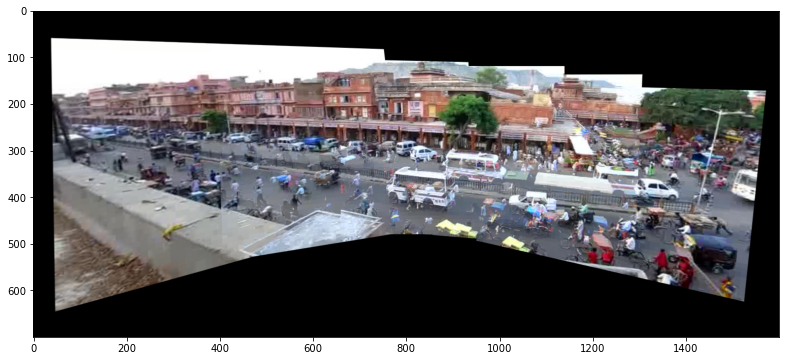

In [145]:
# calculate the square difference cost between two images
def calculate_cost(im1, im2):
    return np.sum((im1 - im2) ** 2, axis=2)

"""
use dynamic programming to identify the path of least cost 
that vertically traverses the entire image, minimizing visible disruptions in the blended result
"""
def find_seam(cost):
    rows, cols = cost.shape
    # create a matrix to store the cumulative minimum cost for each pixel
    cumulative_cost = np.copy(cost)
    
    # create a matrix to store the path to reconstruct the seam
    backtrack = np.zeros_like(cumulative_cost, dtype=np.int32)
    
    for i in range(1, rows):
        for j in range(cols):
            # look at the three adjacent pixels in the previous row
            if j == 0:
                idx = np.argmin(cumulative_cost[i-1, j:j+2])
                backtrack[i, j] = idx + j
                min_energy = cumulative_cost[i-1, idx + j]
            elif j == cols - 1:
                idx = np.argmin(cumulative_cost[i-1, j-1:j+1])
                backtrack[i, j] = idx + j - 1
                min_energy = cumulative_cost[i-1, idx + j - 1]
            else:
                idx = np.argmin(cumulative_cost[i-1, j-1:j+2])
                backtrack[i, j] = idx + j - 1
                min_energy = cumulative_cost[i-1, idx + j - 1]
                
            cumulative_cost[i, j] += min_energy

    # find the end of the seam with the minimum cumulative cost
    seam_end = np.argmin(cumulative_cost[-1])
    seam = np.zeros(rows, dtype=np.int32)
    seam[-1] = seam_end

    # reconstruct the seam path from bottom to top using the backtrack matrix
    for i in range(rows-2, -1, -1):
        seam[i] = backtrack[i+1, seam[i+1]]

    return seam

def blend_on_seam(img1, img2, seam):
    rows = img1.shape[0]
    blended_img = np.zeros_like(img1)

    for i in range(rows):
        seam_col = seam[i]
        blended_img[i, :seam_col] = img1[i, :seam_col]
        blended_img[i, seam_col:] = img2[i, seam_col:]
    
    return blended_img

# compute homographies between consecutive frames.
def compute_homographies(frames):
    homographies = []
    mid = len(frames) // 2
    for i in range(1, len(frames)):
        if i <= mid:
            homography = auto_homography(frames[i-1], frames[i], computeHomography)
        else:
            homography = auto_homography(frames[i], frames[i - 1], computeHomography)
        homographies.append(homography)
    return homographies

# apply transformations to frames and blend them. 
def apply_transformations(frames, transformations, Tr, width, height):
    blend = np.zeros((height, width, 3), dtype=np.uint8)  # Make sure dtype matches expected image type
    previous_transformed_image = None  # Initialize the variable

    for i, (frame, transform) in enumerate(zip(frames, transformations)):
        current_transformed_image = cv2.warpPerspective(frame, np.dot(Tr, transform), (width, height))
        
        if previous_transformed_image is not None:
            cost = calculate_cost(previous_transformed_image, current_transformed_image)
            seam = find_seam(cost)
            blended_current = blend_on_seam(previous_transformed_image, current_transformed_image, seam)
            blend = np.maximum(blend, blended_current)
        else:
            blend = current_transformed_image
        
        previous_transformed_image = current_transformed_image
    
    return blend

key_frames_idx = np.array([90, 270, 450, 630, 810])-1
frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
    frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

projectedWidth = 1600
projectedHeight = 700
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

homographies = compute_homographies(frames)
transformations = [
    np.dot(homographies[1], homographies[0]),  
    homographies[1],                           
    np.identity(3),                          
    homographies[2],
    np.dot(homographies[3], homographies[2])
]

blend = apply_transformations(frames, transformations, Tr, projectedWidth, projectedHeight)
plt.figure(figsize=(15,6))
plt.imshow(blend[:, :, [2, 1, 0]]) 
plt.show()